In [1]:
%matplotlib inline

In [3]:
# from ipywidgets import Button, VBox, HBox, Dropdown

# HBox([HBox([Button(), Button(), Button(), Button()]),
#       HBox([Button(), Dropdown()])
# ])

In [4]:
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
limit_mem()

In [7]:
path = '/home/ubuntu/nbs/dataset/'

In [8]:
arr_lr = bcolz.open(path+'trn_resized_72.bc')
arr_hr = bcolz.open(path+'trn_resized_288.bc')

In [9]:
params = {'verbose': 0, 'callbacks':[TQDMNotebookCallback(leave_inner=True)]}

In [10]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

In [11]:
def res_block(inp, nf=64):
    x = conv_block(inp, nf, 3, (1, 1))
    x = conv_block(x, nf, 3, (1, 1), act = False) # Not wise to add activations on last conv. layer of Residual Block
    return merge([x, inp], mode = 'sum')

In [12]:
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

In [13]:
inp = Input(arr_lr.shape[1:])
x = conv_block(inp, 64, 9, (1, 1))
for i in range(4): x=res_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x+1)*127.5)(x)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (9, 9), strides=(1, 1), padding="same")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Up

In [15]:
shp = arr_hr.shape[1:]
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [16]:
# shp
vgg_inp = Input(shp)
vgg = VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

In [17]:
for l in vgg.layers: l.trainable=False

In [18]:
def get_out(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_out(vgg, o) for o in [1, 2, 3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [19]:
def mean_sqr_b(diff):
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

In [20]:
w = [0.1, 0.8, 0.1]
def content_fn(x):
    res = 0; n = len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n])*w[i]
    return res

In [21]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

In [22]:
m_sr.compile('adam', 'mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **params)

HBox(children=(IntProgress(value=0, description='Training', max=2), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=19439), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 1', max=19439), HTML(value='')))

In [30]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 16, 1, **params)

HBox(children=(IntProgress(value=0, description='Training', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=19439), HTML(value='')))

In [27]:
# top_model = Model(inp, outp)
# p = top_model.predict(arr_lr[51:52])

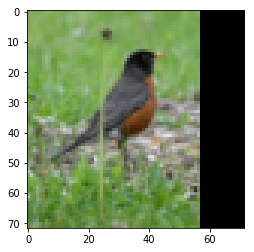

In [28]:
# Before learning rate annealing
# plt.imshow(arr_lr[51].astype('uint8'));

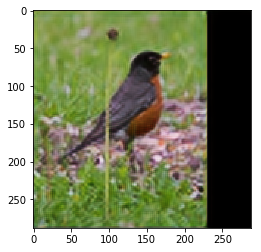

In [29]:
# plt.imshow(p[0].astype('uint8'))

In [31]:
top_model = Model(inp, outp)
p = top_model.predict(arr_lr[51:52])

In [35]:
# After learning rate annealing 

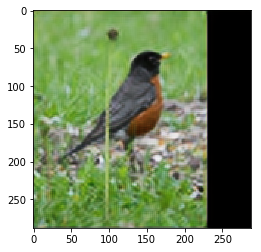

In [33]:
plt.imshow(p[0].astype('uint8'))